In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import collections
# from sklearn.metrics import accuracy_score

In [3]:
data = pd.read_csv('reviews.csv')
data = data[['cleaned_review', 'sentiments']].reset_index(drop=True)
data = data.rename(columns={'cleaned_review': 'text', 'sentiments': 'review_score'})
data['text'] = data['text'].astype(str)
data = data[(data['text'] != '') & (data['text'] != ' ')]
data.loc[data['review_score'] == 'negative', 'review_score'] = 0
data.loc[data['review_score'] == 'neutral', 'review_score'] = 1
data.loc[data['review_score'] == 'positive', 'review_score'] = 2
data.head(10)

,text,review_score
0,i wish would have gotten one earlier love it a...,2
1,i ve learned this lesson again open the packag...,1
2,it is so slow and lags find better option,1
3,roller ball stopped working within months of m...,1
4,i like the color and size but it few days out ...,1
5,overall love this mouse the size weight clicki...,2
6,it stopped working,1
7,my son uses school issued chromebook for schoo...,2
8,loved this cute little mouse but it broke afte...,0
9,should ve spent the money to get quality produ...,0


2    9503
1    6287
0    1534
Name: review_score, dtype: int64


<AxesSubplot: title={'center': 'sentiment score distribution'}>

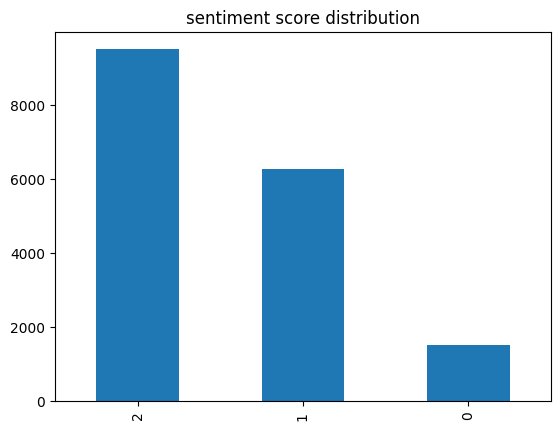

In [4]:
data = data.sample(frac=1).reset_index(drop=True)
print(data["review_score"].value_counts())
data['review_score'].value_counts().plot(kind='bar', title='sentiment score distribution')

In [5]:
X = data['text'].values
X = [review.split(' ') for review in X]
Y = data['review_score'].values.astype(float)
X

[['i',
  'used',
  'this',
  'product',
  'once',
  'and',
  'tried',
  'to',
  'use',
  'it',
  'for',
  'my',
  'work',
  'laptop',
  'and',
  'the',
  'usb',
  'broke',
  'inside',
  'the',
  'laptop',
  'can',
  'get',
  'it',
  'out',
  'dont',
  'buy',
  'this',
  'it',
  'cheaply',
  'made'],
 ['i',
  'bought',
  'these',
  'headphones',
  'for',
  'use',
  'on',
  'xbox',
  'and',
  'they',
  'sisnt',
  'even',
  'work',
  'with',
  'sound',
  'was',
  'then',
  'shipped',
  'another',
  'pair',
  'not',
  'the',
  'same',
  'hunterspider',
  'gaming',
  'headset',
  'headphones',
  'for',
  'ps',
  'ps',
  'switch',
  'xbox',
  'one',
  'pc',
  'with',
  'microphone',
  'noise',
  'reduction',
  'surround',
  'sound',
  'led',
  'light',
  'blue',
  'these',
  'were',
  'given',
  'to',
  'me',
  'instead',
  'and',
  'the',
  'mic',
  'doesnt',
  'even',
  'work',
  'on',
  'these',
  ''],
 ['thinnest', 'mouse', 'have', 'ever', 'seen', ''],
 ['super',
  'comfortable',
  'flex

In [6]:
# build mappings
words = [word for review in X for word in review]
most_common = collections.Counter(words).most_common(round(len(set(words))*1)) # 80% most common words
most_common_words = [word for word, _ in most_common]
str_to_inx = {str:inx for inx, str in enumerate(most_common_words)}
inx_to_str = {inx:str for inx, str in enumerate(most_common_words)}
len(str_to_inx)

9595

In [7]:
# build dataset
X_set = []
for review in X:
    encoded_review = []
    for word in review:
        if word in most_common_words:
            encoded_review.append(str_to_inx[word])
    X_set.append(encoded_review)

max_len = len(max(X_set, key=len))
for review in X_set: 
    review.extend([0]*(max_len-len(review))) # pad with zeros

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
X_set = torch.tensor(X_set, dtype=torch.long).to(device)
Y_set = torch.tensor(Y, dtype=torch.long).to(device)
X_set.shape, Y_set.shape

(torch.Size([17324, 572]), torch.Size([17324]))

In [10]:
# data set splits 80%, 10%, 10%
train_range = round(len(X_set) * 0.8)
dev_range = (len(X_set) - train_range) // 2

training_set = X_set[:train_range]
dev_set = X_set[train_range:train_range+dev_range]
test_set = X_set[train_range+dev_range:]

y_training_set = Y_set[:train_range]
y_dev_set = Y_set[train_range:train_range+dev_range]
y_test_set = Y_set[train_range+dev_range:]

assert training_set.nelement() + dev_set.nelement() + test_set.nelement() == X_set.nelement(), "Bad split"

In [11]:
n_embd = 64 # dim of the character embedding vector
n_hidden = 50 # the # of neurons in the hidden layer
block_size = X_set.shape[1] # the length of the input vector
vocab_size = len(inx_to_str) # the size of the vocabulary
n_categories = 3 # the number of classes
g = torch.Generator().manual_seed(2147483647)

class MLP(nn.Module):
    def __init__(self, vocab_size, n_embd):
        super().__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Dropout(p=0.35), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Dropout(p=0.35), nn.Tanh(),
            nn.Linear(n_hidden, n_categories), nn.BatchNorm1d(n_categories)
        )

    def forward(self, x):
        logits = self.linear_tanh_stack(x)
        return logits

In [12]:
model = MLP(vocab_size=vocab_size, n_embd=n_embd).to(device)
print(model)

MLP(
  (linear_tanh_stack): Sequential(
    (0): Embedding(9595, 64)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=36608, out_features=50, bias=False)
    (3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.35, inplace=False)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=50, bias=False)
    (7): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.35, inplace=False)
    (9): Tanh()
    (10): Linear(in_features=50, out_features=3, bias=True)
    (11): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [13]:
sum(p.nelement() for p in model.parameters())

2447339

In [14]:
losses, inxs = [], []

In [38]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)
steps = 5000
batch_size = 64
model.train()
for epoch in range(steps):
    inx = torch.randint(0, training_set.shape[0], (batch_size,), generator=g)
    emb = training_set[inx] # grab only those rows from the minibatch 

    optimizer.zero_grad()

    # forward pass
    preds = model(emb)
    loss = loss_function(preds, y_training_set[inx])

    # backward pass
    loss.backward()

    # update the weights
    optimizer.step()

    #stats
    if epoch % 1000 == 0: # print every once in a while
        print(f'{epoch:7d}/{steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())
    inxs.append(epoch)
   
loss

      0/      1: 0.2230


tensor(0.2230, device='cuda:0', grad_fn=<NllLossBackward0>)

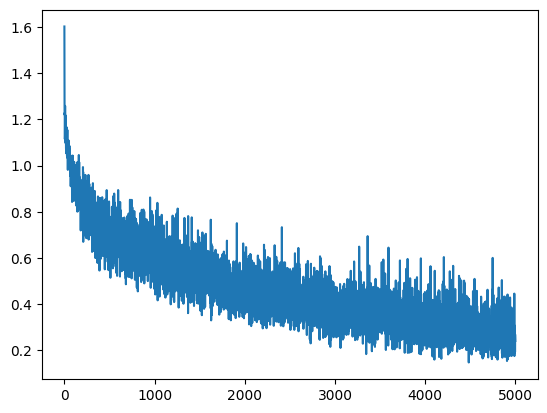

In [16]:
# plot loss
import numpy as np
plt.plot(inxs, (losses))
# plt.xscale("log")

In [35]:
torch.cuda.empty_cache()
@torch.no_grad() # disable gradient tracking
def get_loss(model, data_set):
    model.eval()
    x, y = {
        'train': (training_set[:10000], y_training_set[:10000]),
        'dev': (dev_set, y_dev_set),
        'test': (test_set, y_test_set)
    }[data_set]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(data_set, loss.item())

# get_loss(model,'train')
get_loss(model,'dev')
# get_loss(model,'test')

dev 0.9113739728927612


In [36]:
# accuracy on the specified set
@torch.no_grad()
def get_accuracy(model, set, set_labels):
    model.eval()
    correct = 0
    total = set_labels.size(0)

    logits = model(set)
    probs = F.softmax(logits, dim=1)

    predicted = torch.argmax(probs.data, 1)
    print(predicted, set_labels)
    correct = (predicted == set_labels).sum().item()
    # correct = accuracy_score(set_labels.cpu().numpy(), predicted.cpu().numpy())
    print(pd.DataFrame(predicted.cpu().numpy()).value_counts())

    print(f'Accuracy of the network on the {set_labels.size(0)} test reviews: {100 * correct // total} %')
get_accuracy(model, test_set, y_test_set)

tensor([1, 2, 2,  ..., 2, 0, 0], device='cuda:0') tensor([1, 1, 2,  ..., 2, 2, 1], device='cuda:0')
2    977
1    598
0    158
dtype: int64
Accuracy of the network on the 1733 test reviews: 75 %


In [37]:
# sample from the model
sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}
@torch.no_grad()
def sample(model, rev):
    model.eval()
    rev = rev.split(' ')
    x = torch.tensor([str_to_inx[x] for x in rev] + [0]*(X_set.shape[1]-len(rev)), dtype=torch.long).to(device)
    x = x.view(1, -1)
    logits = model(x)
    probs = F.softmax(logits, dim=1)
    # print(probs.data)
    predicted = torch.argmax(probs.data, dim=1)
    return probs, sentiment[predicted.item()]

print(sample(model, 'i hate this product'))
print(sample(model, 'i like this product'))
sample(model, 'i love this product')

(tensor([[0.1014, 0.6898, 0.2088]], device='cuda:0'), 'neutral')
(tensor([[0.0059, 0.9399, 0.0541]], device='cuda:0'), 'neutral')


(tensor([[0.0045, 0.0110, 0.9845]], device='cuda:0'), 'positive')